In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/FYP/chest_xray_MobileNetV3_Augmentation>.zip -d /content/extracted_files

In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras import layers, models, optimizers
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
import matplotlib.pyplot as plt

In [4]:
# Step 1: Set up paths for the dataset
dataset_dir = "/content/extracted_files/chest_xray_MobileNetV3_Augmentation"

# Define paths for training and testing
train_dir = os.path.join(dataset_dir, "/content/extracted_files/chest_xray_MobileNetV3_Augmentation/train")
test_dir = os.path.join(dataset_dir, "/content/extracted_files/chest_xray_MobileNetV3_Augmentation/test")


In [5]:
# Image dimensions and batch size
img_height, img_width = 224, 224  # MobileNetV3 recommended input size
batch_size = 32


In [6]:
# Step 1: Data Augmentation and Loading
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=10,   # Moderate rotation
    width_shift_range=0.05,  # Small width shift
    height_shift_range=0.05, # Small height shift
    zoom_range=0.05,     # Small zoom
    horizontal_flip=True,
    validation_split=0.2  # Reserve 20% of training data for validation
)

In [7]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="binary",
    subset="training"
)

Found 4187 images belonging to 2 classes.


In [8]:
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="binary",
    subset="validation"
)

Found 1045 images belonging to 2 classes.


In [9]:
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="binary",
    shuffle=False
)

Found 624 images belonging to 2 classes.


In [10]:
# Step 2: Compute Class Weights
train_classes = train_generator.classes
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_classes),
    y=train_classes
)
class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weights_dict)


Class Weights: {0: 1.938425925925926, 1: 0.6738010943031864}


In [11]:
# Step 3: Build MobileNetV3 Model
base_model = MobileNetV3Small(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights="imagenet"
)

4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [12]:
# Freeze base model
base_model.trainable = False


In [13]:
# Add custom layers
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

In [14]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ MobileNetV3Small (Functional)        │ (None, 7, 7, 576)           │         939,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 576)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,013,105 (3.86 MB)

 Trainable params: 73,985 (289.00 KB)

 Non-trainable params: 939,120 (3.58 MB)

In [16]:
# Step 4: Train the Model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,  # Adjust epochs as needed
    verbose=1,
    class_weight=class_weights_dict  # Apply class weights
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


131/131 ━━━━━━━━━━━━━━━━━━━━ 182s 1s/step - accuracy: 0.4564 - loss: 0.7155 - val_accuracy: 0.7426 - val_loss: 0.6329
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 196s 1s/step - accuracy: 0.5298 - loss: 0.6934 - val_accuracy: 0.2574 - val_loss: 0.7281
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 176s 1s/step - accuracy: 0.5321 - loss: 0.6860 - val_accuracy: 0.5091 - val_loss: 0.6932
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 171s 1s/step - accuracy: 0.5329 - loss: 0.6848 - val_accuracy: 0.7426 - val_loss: 0.6488
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.6276 - loss: 0.6743 - val_accuracy: 0.6411 - val_loss: 0.6858
Epoch 6/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.5799 - loss: 0.6755 - val_accuracy: 0.4842 - val_loss: 0.6965
Epoch 7/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 169s 1s/step - accuracy: 0.5811 - loss: 0.6731 - val_accuracy: 0.5206 - val_loss: 0.6932
Epoch 8/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 208s 1s/step - accuracy: 0.5851 - loss: 0.6704 - val_accuracy: 0.725

In [17]:
# Step 5: Evaluate the Model
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 790ms/step - accuracy: 0.5801 - loss: 0.6676
Test Accuracy: 71.63%


In [18]:
# Step 6: Predictions and Metrics
y_pred = (model.predict(test_generator) > 0.5).astype("int32")
y_true = test_generator.classes

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys(), zero_division=0))


20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 657ms/step

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.66      0.51      0.57       234
   PNEUMONIA       0.74      0.84      0.79       390

    accuracy                           0.72       624
   macro avg       0.70      0.67      0.68       624
weighted avg       0.71      0.72      0.71       624



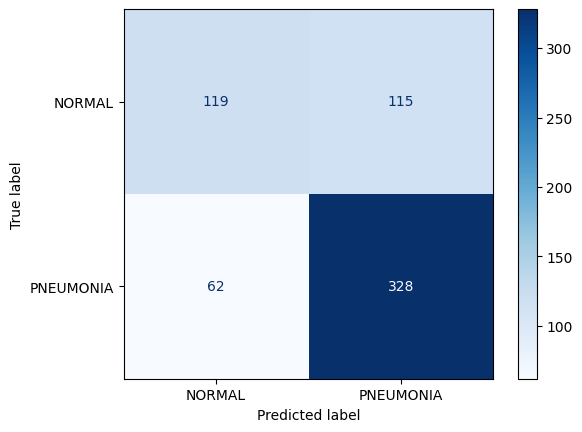

In [19]:
# Step 7: Confusion Matrix
confusion_mtx = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mtx, display_labels=test_generator.class_indices.keys())
disp.plot(cmap="Blues")
plt.show()


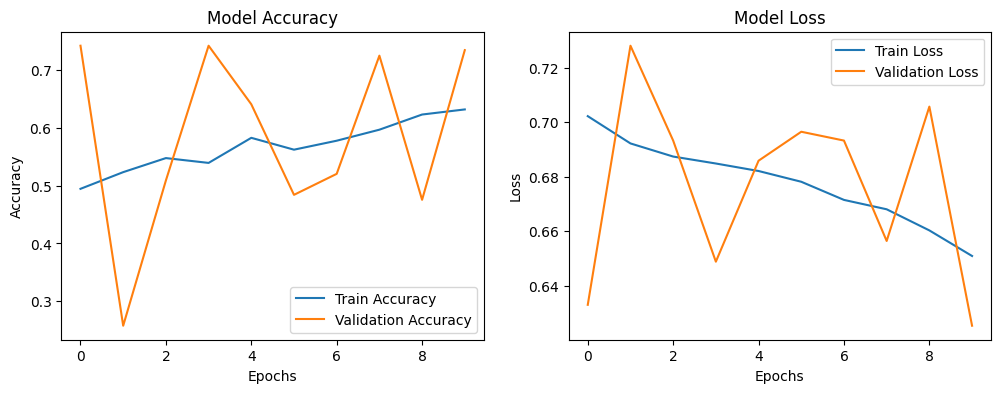

In [20]:
# Optional: Plot Training History
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()
